In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from plotly.subplots import make_subplots
from IPython.display import HTML, display
from scipy.stats import skew, kurtosis

✅ Dataset cargado correctamente desde Google Drive.

🔎 Valores nulos por columna (antes de limpieza):
Date                                      0
Time                                      0
Booking ID                                0
Booking Status                            0
Customer ID                               0
Vehicle Type                              0
Pickup Location                           0
Drop Location                             0
Avg VTAT                              10500
Avg CTAT                              48000
Cancelled Rides by Customer          139500
Reason for cancelling by Customer    139500
Cancelled Rides by Driver            123000
Driver Cancellation Reason           123000
Incomplete Rides                     141000
Incomplete Rides Reason              141000
Booking Value                         48000
Ride Distance                         48000
Driver Ratings                        57000
Customer Rating                       57000
Payment Method    

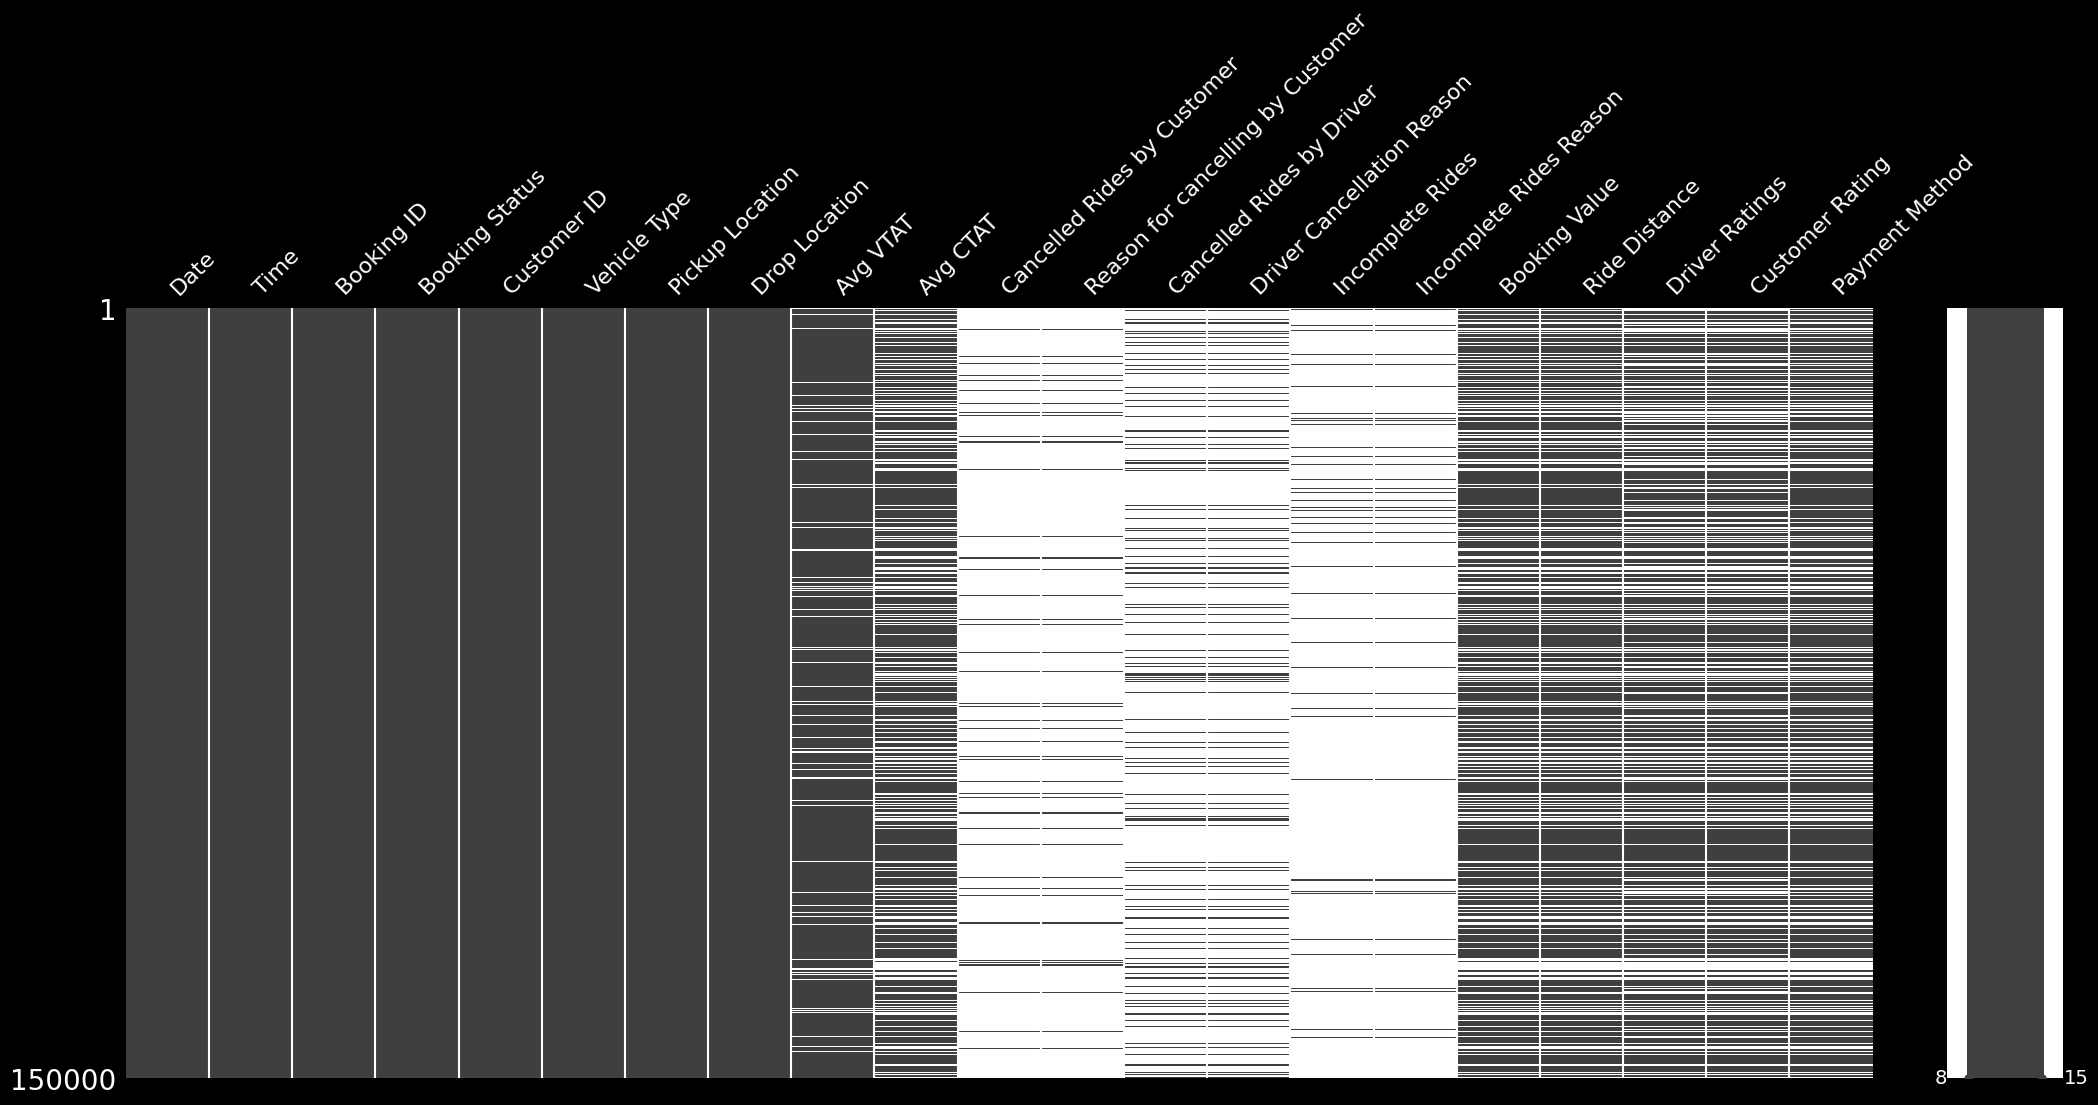


🔎 Valores nulos por columna (después de limpieza):
Date                                 0
Time                                 0
Booking ID                           0
Booking Status                       0
Customer ID                          0
Vehicle Type                         0
Pickup Location                      0
Drop Location                        0
Avg VTAT                             0
Avg CTAT                             0
Cancelled Rides by Customer          0
Reason for cancelling by Customer    0
Cancelled Rides by Driver            0
Driver Cancellation Reason           0
Incomplete Rides                     0
Incomplete Rides Reason              0
Booking Value                        0
Ride Distance                        0
Driver Ratings                       0
Customer Rating                      0
Payment Method                       0
Hour                                 0
dtype: int64

🔍 Visualizando valores nulos...


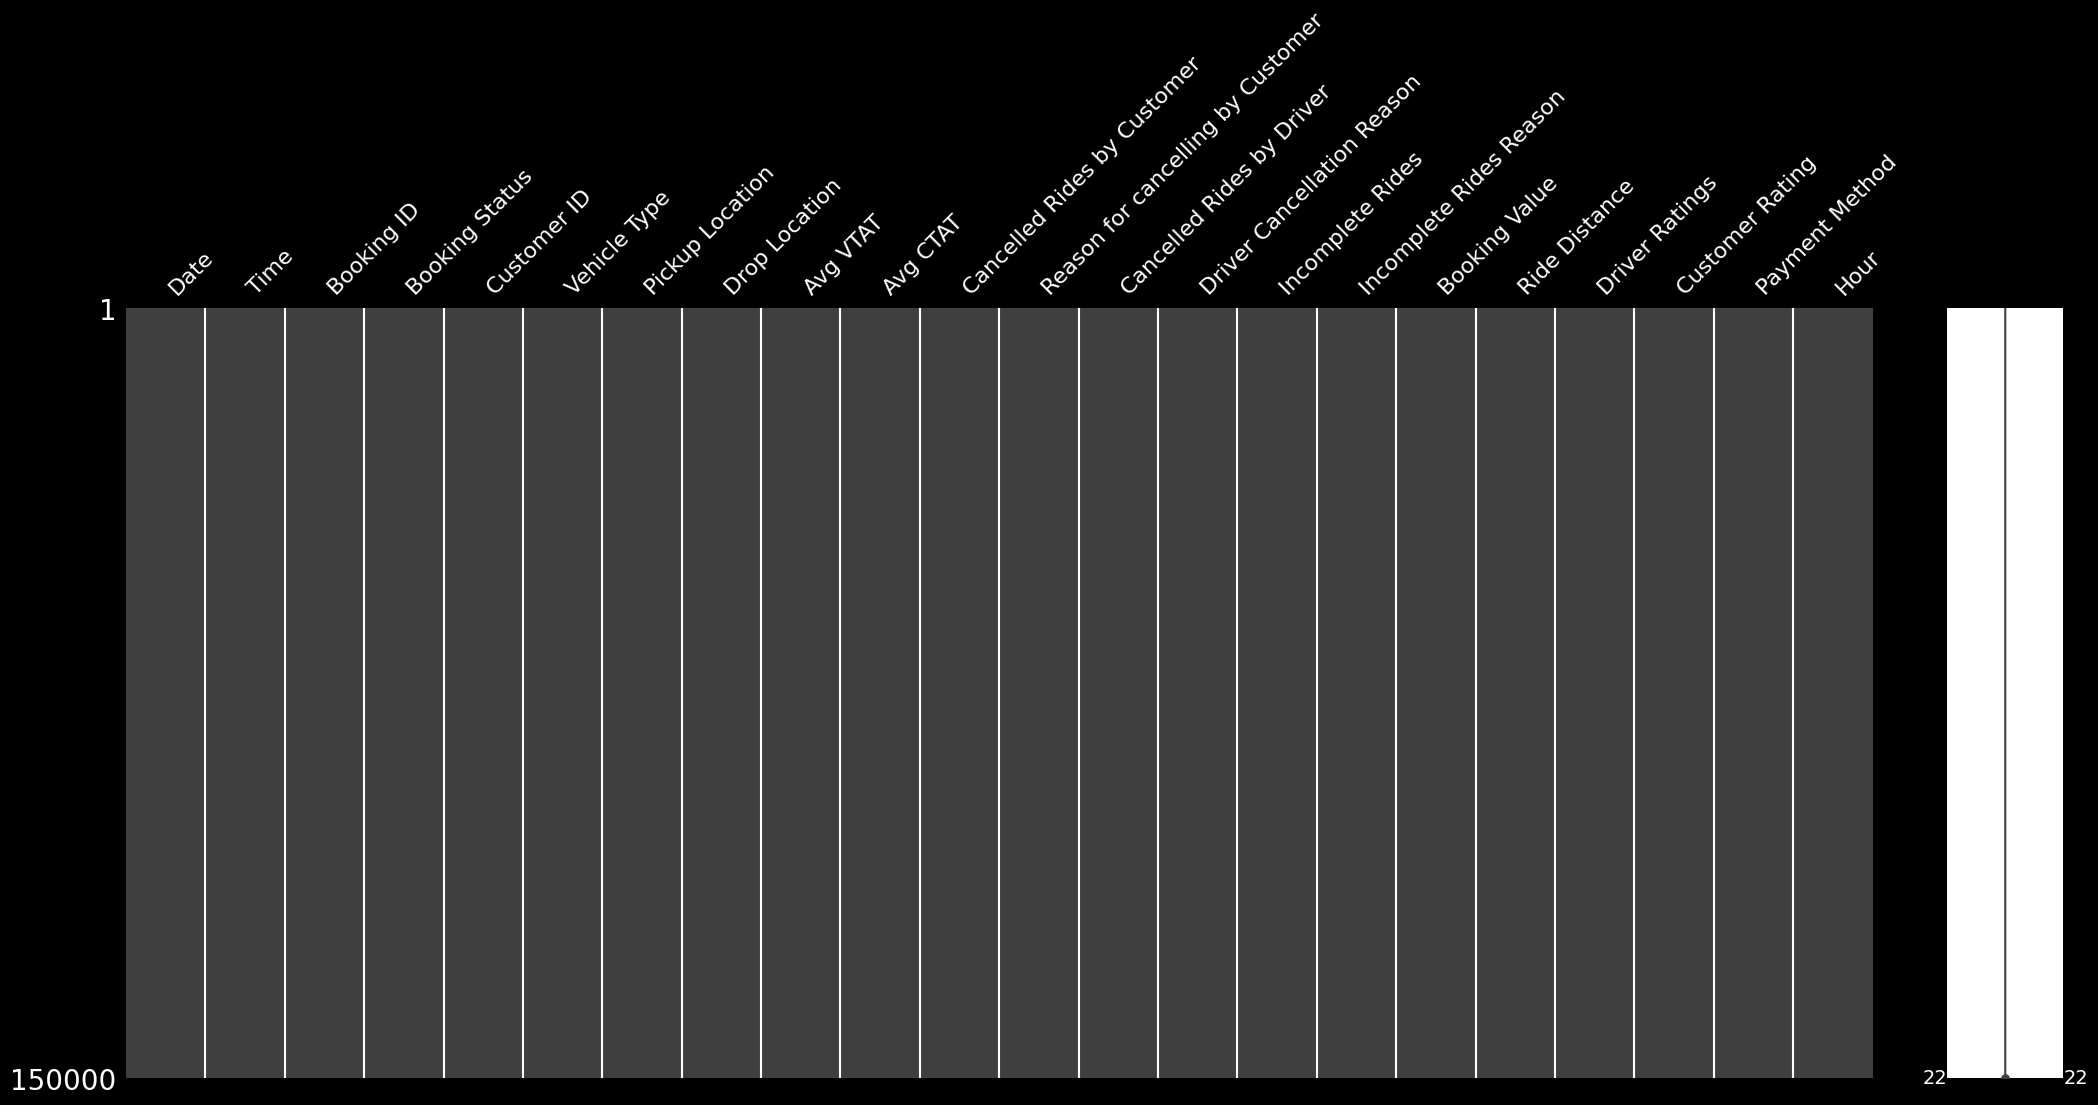


📏 Dimensiones del dataset: (150000, 22)

📝 Columnas del dataset: ['Date', 'Time', 'Booking ID', 'Booking Status', 'Customer ID', 'Vehicle Type', 'Pickup Location', 'Drop Location', 'Avg VTAT', 'Avg CTAT', 'Cancelled Rides by Customer', 'Reason for cancelling by Customer', 'Cancelled Rides by Driver', 'Driver Cancellation Reason', 'Incomplete Rides', 'Incomplete Rides Reason', 'Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating', 'Payment Method', 'Hour']


In [2]:
# ============================================
# ⚙️ Configuración inicial
# ============================================
pd.set_option("display.max_columns", None)  # Muestra todas las columnas
pd.set_option("display.precision", 3)       # Menos decimales para mejor lectura

# ============================================
# 📂 Cargar Dataset de Uber desde Google Drive
# ============================================
FILE_ID = "1dHvSNZHF8XK1BNT5puwlZzxId3IAQFeI"
DATASET_URL = f"https://drive.google.com/uc?id={FILE_ID}"

def load_uber_dataset(url: str) -> pd.DataFrame:
    """Carga el dataset desde Google Drive y maneja errores de parsing."""
    try:
        df = pd.read_csv(url, delimiter=',')
        print("✅ Dataset cargado correctamente desde Google Drive.")
        return df
    except pd.errors.ParserError as e:
        raise ValueError(f"❌ Error al parsear el CSV: {e}")
    except Exception as e:
        raise RuntimeError(f"❌ No se pudo cargar el dataset: {e}")


# ============================================
# 📊 Visualización de valores nulos
# ============================================
def visualize_missing_data(df: pd.DataFrame) -> None:
    """
    Visualiza los valores nulos en el dataset usando missingno.
    Muestra matriz, gráfico de barras y heatmap para detectar patrones de ausencia de datos.
    """
    print(df.isna().sum())
    plt.style.use("dark_background")
    print("\n🔍 Visualizando valores nulos...")
    # 1️⃣ Matriz de nulos (orden temporal si hay una columna de tiempo)
    msno.matrix(df)
    plt.show()


# ============================================
# 🔧 Función de limpieza y preparación
# ============================================

def clean_uber_data_sklearn(df: pd.DataFrame) -> pd.DataFrame:
    # 1️⃣ Columnas numéricas: rellenar con 0
    numeric_cols = df.select_dtypes(include='number').columns
    num_imputer = SimpleImputer(strategy='constant', fill_value=0)
    df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

    # 2️⃣ Columnas de texto: rellenar con 'Desconocido'
    object_cols = df.select_dtypes(include='object').columns
    cat_imputer = SimpleImputer(strategy='constant', fill_value='Desconocido')
    df[object_cols] = cat_imputer.fit_transform(df[object_cols])

    # 3️⃣ Extraer hora del día de la columna Time
    if 'Time' in df.columns:
        df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
        df['Hour'] = df['Hour'].fillna(-1).astype(int)

    return df

# ============================================
# 🚀 Uso de las funciones
# ============================================
df_uber = load_uber_dataset(DATASET_URL)
print("\n🔎 Valores nulos por columna (antes de limpieza):")
visualize_missing_data(df_uber)
clean_uber_data_sklearn(df_uber)
print("\n🔎 Valores nulos por columna (después de limpieza):")
visualize_missing_data(df_uber)

# ============================================
# 🔍 Exploración inicial
# ============================================
print("\n📏 Dimensiones del dataset:", df_uber.shape)
print("\n📝 Columnas del dataset:", df_uber.columns.tolist())

In [4]:
# @title Funciones
def extract_hour(df, time_col='Time', new_col='HourFromTime'):
    """Crea una columna con la hora extraída de la columna de tiempo, sin modificar el original."""
    df_copy = df.copy()
    df_copy[time_col] = df_copy[time_col].astype(str)
    df_copy[new_col] = pd.to_datetime(
        df_copy[time_col],
        format='%H:%M:%S',
        errors='coerce'
    ).dt.hour
    return df_copy


def create_distance_bins(df, col='Ride Distance', bin_size=5):
    """
    Crea bins de distancia agrupando cada `bin_size` km (por defecto 5 km),
    sin modificar el DataFrame original.

    - Genera etiquetas automáticas como '0-5 km', '5-10 km', etc.
    - El último bin se marca como 'X+ km' si hay distancias mayores al último múltiplo de bin_size.
    """
    # Hacemos copia para no modificar el DataFrame original
    df_copy = df.copy()

    # Calcular la distancia máxima presente en el dataset
    max_distance = df_copy[col].max()

    # Crear límites hasta cubrir el máximo (se agrega un bin extra si es necesario)
    bins = np.arange(0, max_distance + bin_size, bin_size)

    # Generar etiquetas automáticas para cada rango
    labels = [f"{int(bins[i])}-{int(bins[i+1])} km" for i in range(len(bins)-1)]

    # Si hay viajes mayores al último bin, agregar un bin abierto (ej. "25+ km")
    if max_distance > bins[-1]:
        bins = np.append(bins, max_distance + 1)
        labels.append(f"{int(bins[-2])}+ km")

    # Crear la nueva columna con los bins
    df_copy['DistanceBin'] = pd.cut(df_copy[col], bins=bins, labels=labels, right=False)

    # Devolver el DataFrame modificado
    return df_copy


def create_hour_bins(df, col='HourFromTime'):
    """Crea franjas horarias de 1 hora sin modificar el DataFrame original."""
    df_copy = df.copy()
    bins = list(range(0, 25, 1))
    labels = [f"{i}:00-{i+1}:00" for i in range(24)]
    df_copy['HourBin'] = pd.cut(df_copy[col], bins=bins, labels=labels, right=False, include_lowest=True)
    return df_copy

In [5]:
# =======================================================
# Helpers de preparación
# =======================================================
def prepare_dfv(df_uber: pd.DataFrame) -> pd.DataFrame:
    df1 = extract_hour(df_uber, time_col='Time', new_col='HourFromTime')

    d = df1.copy()
    d["Booking Value"] = pd.to_numeric(d["Booking Value"], errors="coerce")
    d["Ride Distance"]  = pd.to_numeric(d["Ride Distance"],  errors="coerce")

    # Filtrado básico
    mask_valid = (
        d["Booking Value"].notna() & (d["Booking Value"] > 0) &
        d["Ride Distance"].notna() & (d["Ride Distance"] > 0) &
        d["HourFromTime"].notna()
    )
    dfv = d.loc[mask_valid].copy()

    # Bins
    dfv = create_distance_bins(dfv, col="Ride Distance", bin_size=5)
    dfv = create_hour_bins(dfv, col="HourFromTime")

    # Precio/km
    dfv["valor_km"]   = dfv["Booking Value"] / dfv["Ride Distance"]
    dfv["valor_km_w"] = dfv["valor_km"]
    return dfv


def compute_series_hora(dfv: pd.DataFrame) -> pd.DataFrame:
    """Precio mediano por km según la hora."""
    serie_hora = (
        dfv.groupby("HourFromTime", observed=True)["valor_km_w"]
           .median().reset_index()
           .rename(columns={"HourFromTime":"hour"})
           .sort_values("hour")
    )
    return serie_hora


def compute_rank_zona(dfv: pd.DataFrame, MIN_SUPPORT_ZONE: int) -> pd.DataFrame:
    """Ranking de zonas por mediana de precio/km con soporte mínimo."""
    valid_zones = dfv["Pickup Location"].value_counts().loc[lambda s: s >= MIN_SUPPORT_ZONE].index #representativo
    rank_zona = (
        dfv[dfv["Pickup Location"].isin(valid_zones)]
          .groupby("Pickup Location", observed=True)["valor_km_w"]
          .median().rename("mediana_valor_km")
          .reset_index()
          .sort_values("mediana_valor_km", ascending=False)
    )
    return rank_zona


# =======================================================
# Funciones de GRÁFICOS
# =======================================================

# Paleta NEÓN

NEON = {
    "cyan":    "#00FFF0",
    "magenta": "#FF00FF",
    "lime":    "#A8FF00",
    "pink":    "#FF4DFF",
    "orange":  "#FF6B00",
    "yellow":  "#FFFF33"
}

def _rgba(hex_color, alpha=0.25):  #hexadecimal --> rgba
    """Hex -> rgba(r,g,b,a) para halos."""
    hex_color = hex_color.lstrip("#")
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    return f"rgba({r},{g},{b},{alpha})"


def dashboard_precio_interactivo(serie_hora: pd.DataFrame,
                                 rank_zona: pd.DataFrame,
                                 TOP_N: int = 20) -> None:

    # --- datos ---
    med_global = float(serie_hora["valor_km_w"].median())
    rz = rank_zona.head(TOP_N).copy()

    # Colores neón a usar
    c_hora = NEON["cyan"]
    c_zona = NEON["magenta"]
    c_med  = NEON["lime"]

    # --- layout con 2 subplots del mismo tamaño ---
    fig = make_subplots(
        rows=1, cols=2,
        horizontal_spacing=0.08,
        subplot_titles=("Precio por km vs hora (mediana)",
                        f"Precio por km por zona (Top {TOP_N})")
    )

    # ---------- (1) línea por hora ----------
    # Halo
    fig.add_trace(
        go.Scatter(
            x=serie_hora["hour"], y=serie_hora["valor_km_w"],
            mode="lines",
            line=dict(color=_rgba(c_hora, 0.25), width=10),
            hoverinfo="skip", showlegend=False
        ),
        row=1, col=1
    )
    # Trazo principal
    fig.add_trace(
        go.Scatter(
            x=serie_hora["hour"], y=serie_hora["valor_km_w"],
            mode="lines+markers", name="Mediana por hora",
            line=dict(color=c_hora, width=3),
            marker=dict(color=c_hora, size=7)
        ),
        row=1, col=1
    )

    fig.add_hline(
        y=med_global,
        line_dash="dot",
        line_color=c_med,
        annotation_text=f"Mediana global: {med_global:.2f}",
        annotation_position="top left",
        annotation=dict(font=dict(color=c_med, size=12)),
        row=1, col=1
    )

    # ---------- (2) serie por zona (orden Top_N) ----------
    # Halo
    fig.add_trace(
        go.Scatter(
            x=rz["Pickup Location"], y=rz["mediana_valor_km"],
            mode="lines",
            line=dict(color=_rgba(c_zona, 0.25), width=10),
            hoverinfo="skip", showlegend=False
        ),
        row=1, col=2
    )
    # Trazo principal
    fig.add_trace(
        go.Scatter(
            x=rz["Pickup Location"], y=rz["mediana_valor_km"],
            mode="markers+lines", name="Mediana por zona",
            line=dict(color=c_zona, width=3),
            marker=dict(color=c_zona, size=7)
        ),
        row=1, col=2
    )

    # --- estilo / ejes ---
    fig.update_layout(
        width=1200, height=450,  # mismo alto/ancho para ambos
        showlegend=False,
        template="plotly_dark",
        margin=dict(l=40, r=20, t=60, b=60),
        plot_bgcolor="#111318",
        paper_bgcolor="#111318",
        font=dict(color="#EAF6FF")
    )

    # Eje x de horas: ticks de 1 en 1
    fig.update_xaxes(title_text="Hora del día", dtick=1,
                     gridcolor="rgba(255,255,255,0.08)", row=1, col=1)
    fig.update_yaxes(title_text="Mediana precio/km",
                     gridcolor="rgba(255,255,255,0.08)", row=1, col=1)

    # Eje x de zonas: rotación para legibilidad y orden categórico fijo
    fig.update_xaxes(
        title_text="Pickup Location",
        tickangle=75,
        categoryorder="array",
        categoryarray=rz["Pickup Location"].tolist(),
        gridcolor="rgba(255,255,255,0.08)",
        row=1, col=2
    )
    fig.update_yaxes(title_text="Mediana precio/km",
                     gridcolor="rgba(255,255,255,0.08)", row=1, col=2)

    fig.show()



# =======================================================
# BLOQUE DE FLUJO
# =======================================================
MIN_SUPPORT_ZONE = 50
TOP_N = 20

# 0) Preparación
dfv = prepare_dfv(df_uber)

# 1) Agregados base
serie_hora = compute_series_hora(dfv)
rank_zona  = compute_rank_zona(dfv, MIN_SUPPORT_ZONE)

dashboard_precio_interactivo(serie_hora, rank_zona, TOP_N=50)


In [6]:
# @title 📊 Resultado y Conclusión
html = r"""
<style>
  :root{
    --bg1:#1e1e2f; --bg2:#2c3e50;
    --text:#f0f0f0; --accent:#4cafef; --accent2:#00ffe0;
    --muted:#b8c2cc;
  }
  *{box-sizing:border-box}
  body{
    margin:0;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    background: linear-gradient(120deg, var(--bg1), var(--bg2));
    color:var(--text);
    line-height:1.6;
    overflow-x:hidden;
  }
  h2{
    margin:22px 0 10px;
    text-align:center;
    color:var(--accent2);
    text-shadow:0 0 6px var(--accent2);
    letter-spacing:.3px;
  }
  section.card{
    margin:28px auto;
    padding:22px 18px;
    border-radius:16px;
    width:min(920px, 88vw);
    background:rgba(255,255,255,.05);
    border:2px solid var(--accent);
    box-shadow:0 0 18px rgba(76,175,239,.65);
    transition:transform .25s, box-shadow .25s;
  }
  section.card:hover{ transform:scale(1.015); box-shadow:0 0 28px rgba(76,175,239,.85); }

  /* Lista con puntos personalizados */
  .bulleted{
    list-style:none;
    padding-left:0;
    margin:10px auto 2px;
    width:min(760px, 92%);
  }
  .bulleted li{
    position:relative;
    padding-left:36px;
    margin:12px 0;
    text-align:left;
  }
  .bulleted li::before{
    content:"";
    position:absolute; left:0; top:.6em;
    width:12px; height:12px; border-radius:50%;
    background:radial-gradient(circle at 35% 35%, var(--accent2), var(--accent));
    box-shadow:0 0 10px var(--accent2), 0 0 18px var(--accent);
  }

  /* Etiquetas/resaltados cortos */
  .label{ font-weight:700; color:#fff; }
  .chip{
    display:inline-block; padding:.1rem .5rem; margin:0 .2rem;
    border:1px solid var(--accent); border-radius:999px;
    background:rgba(76,175,239,.14);
    font-weight:600; font-size:.95rem;
  }

  /* Párrafo final */
  .conclusion{
    margin-top:12px;
    padding:14px 16px;
    border-radius:12px;
    background:rgba(0,255,224,.08);
    border:1px dashed var(--accent2);
    text-align:left;
  }

  /* Accesibilidad y responsivo */
  @media (max-width:520px){
    .bulleted li{ padding-left:30px; }
    .bulleted li::before{ width:10px; height:10px; top:.55em; }
  }
</style>

<section class="card">
  <h2>📊 Resultado y Conclusión</h2>

  <ul class="bulleted">
    <li>
      <span class="label">Horas:</span>
      se dispara entre <span class="chip">07–12 h</span> (pico <span class="chip">~10–11 h</span>)
      y <span class="chip">20–22 h</span>; cae en
      <span class="chip">05 h</span> y <span class="chip">18–19 h</span>.
    </li>

    <li>
      <span class="label">Zonas (Top del ranking):</span>
      <strong>Saidulajab</strong>, <strong>Tughlakabad</strong>, <strong>Greater Noida</strong>
      — todas con <em>mediana</em> &gt; <span class="chip">21–21.5 precio/km</span>.
    </li>
  </ul>

  <div class="conclusion">
    <strong>🎯 Conclusión:</strong>
    El <em>precio por km</em> aumenta en horas pico y en zonas de alta demanda
    (<em>posible surge</em>). Confirmado por los gráficos: picos claros en horas pico
    y en las zonas del Top.
  </div>
</section>
"""
display(HTML(html))

In [8]:
# @title Analisis univariado Avg CTAT y Time

# Seleccionamos solo las columnas 'Time' y 'Avg CTAT' del DataFrame original
# y creamos una copia independiente para no modificar df_uber directamente
df_eda = df_uber[['Time', 'Avg CTAT']].copy()
# Eliminamos las filas que tienen valores nulos en 'Time' o 'Avg CTAT'
df_eda.dropna(subset=['Time', 'Avg CTAT'], inplace=True)
# Nos quedamos únicamente con las filas donde 'Avg CTAT' es mayor que 0
df_eda = df_eda[df_eda['Avg CTAT'] > 0]
# Convertimos la columna 'Time' al tipo datetime con el formato de hora, minuto y segundo
# Si algún valor no cumple el formato, se convierte a NaT (valor nulo temporal)
df_eda['Time'] = pd.to_datetime(df_eda['Time'], format='%H:%M:%S', errors='coerce')
# Ordenamos el DataFrame de forma ascendente según la columna 'Time'
df_eda = df_eda.sort_values(by='Time')

# Crear columna con solo la hora (entero)
df_eda['Hour'] = df_eda['Time'].dt.hour

# Contar registros por hora
hourly_counts = df_eda.groupby('Hour').size().reset_index(name='Cantidad de registros')

# Calcular promedio de Avg CTAT por hora
avg_ctat_by_hour = df_eda.groupby('Hour')['Avg CTAT'].mean().reset_index()

# Estadísticas descriptivas de 'Avg CTAT'
print("📊 Estadísticas descriptivas de la columna 'Avg CTAT'\n")

# Asimetría
skew_value = skew(df_eda['Avg CTAT'])
print(f"Asimetría (skew): {skew_value:.2f}")
print("→ La asimetría mide el grado de simetría de la distribución.")
print("  En este caso, el valor es muy cercano a 0, lo que indica que los datos están equilibrados,")
print("  sin sesgo hacia valores muy altos ni muy bajos.\n")

# Curtosis
kurt_value = kurtosis(df_eda['Avg CTAT'])
print(f"Curtosis: {kurt_value:.2f}")
print("→ La curtosis mide el grado de concentración y presencia de valores extremos.")
print("  Un valor negativo (como -1.12) indica una distribución más plana.")
print("  con menos valores extremos y los datos más dispersos alrededor de la media.\n")

# Resumen estadístico
summary = df_eda['Avg CTAT'].describe()
print("📈 Resumen estadístico general:")
print(summary)
print("\nInterpretación:")
print("  - count: 102,000 registros analizados → muestra grande y confiable.")
print("  - mean: el valor promedio de 'Avg CTAT' es 29.15.")
print("  - std: la desviación estándar de 8.90 indica una variabilidad moderada.")
print("  - min y max: van de 10 a 45 → rango acotado, sin outliers importantes.")
print("  - 25%, 50%, 75%: la mitad de los datos están entre 21.6 y 36.8.")
print("En conjunto, los tiempos promedio (Avg CTAT) son homogéneos y estables, sin grandes diferencias entre registros.")

📊 Estadísticas descriptivas de la columna 'Avg CTAT'

Asimetría (skew): 0.05
→ La asimetría mide el grado de simetría de la distribución.
  En este caso, el valor es muy cercano a 0, lo que indica que los datos están equilibrados,
  sin sesgo hacia valores muy altos ni muy bajos.

Curtosis: -1.12
→ La curtosis mide el grado de concentración y presencia de valores extremos.
  Un valor negativo (como -1.12) indica una distribución más plana.
  con menos valores extremos y los datos más dispersos alrededor de la media.

📈 Resumen estadístico general:
count    102000.000
mean         29.150
std           8.903
min          10.000
25%          21.600
50%          28.800
75%          36.800
max          45.000
Name: Avg CTAT, dtype: float64

Interpretación:
  - count: 102,000 registros analizados → muestra grande y confiable.
  - mean: el valor promedio de 'Avg CTAT' es 29.15.
  - std: la desviación estándar de 8.90 indica una variabilidad moderada.
  - min y max: van de 10 a 45 → rango acot

In [9]:
# @title Distribución de Avg CTAT

fig = px.histogram(
    df_eda,
    x='Avg CTAT',
    nbins=40,  # más control sobre el número de bins
    title='📊 Distribución del Tiempo Promedio de Viaje (Avg CTAT)',
    labels={'Avg CTAT': 'Tiempo Promedio (min)'},
    opacity=0.8,  # un poco de transparencia
    color_discrete_sequence=['#00BFFF']  # azul más suave
)

fig.update_layout(
    paper_bgcolor='#111111',
    plot_bgcolor='#111111',
    font=dict(color='white'),
    bargap=0.05,
    xaxis=dict(showgrid=True, gridcolor='gray'),
    yaxis=dict(showgrid=True, gridcolor='gray'),
)
fig.show()

In [10]:
# @title Frecuencia temporal de registros

# Graficar
fig = px.bar(
    hourly_counts,
    x='Hour',
    y='Cantidad de registros',
    title='🕒 Distribución de registros por hora del día',
    labels={'Hour': 'Hora del día', 'Cantidad de registros': 'Número de registros'},
    color='Cantidad de registros',
    color_continuous_scale='Viridis'
)

fig.update_layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(tickmode='linear', dtick=1),
)
fig.show()

In [11]:
# @title Análisis bivariado (Time vs Avg CTAT)

# Graficar evolución promedio
fig = px.line(
    avg_ctat_by_hour,
    x='Hour',
    y='Avg CTAT',
    title='📉 Evolución promedio de Avg CTAT por hora del día',
    labels={'Hour': 'Hora del día', 'Avg CTAT': 'Demora promedio (min)'},
    markers=True,
    line_shape='spline',
)

fig.update_traces(line_color='#FF7F50', line_width=3)
fig.update_layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(tickmode='linear', dtick=1)
)

fig.show()

In [12]:
# @title Correlacion simple

df_eda['timestamp'] = df_eda['Time'].astype(np.int64) // 10**9
corr = df_eda['timestamp'].corr(df_eda['Avg CTAT'])
print(f"🔹 Correlación Time–Avg CTAT: {corr:.4f}")
print("El valor -0.0011 está muy cerca de 0, lo que indica una correlación prácticamente nula entre el tiempo del día (Time) y la demora promedio (Avg CTAT).")

🔹 Correlación Time–Avg CTAT: -0.0011
El valor -0.0011 está muy cerca de 0, lo que indica una correlación prácticamente nula entre el tiempo del día (Time) y la demora promedio (Avg CTAT).


In [13]:
# @title Conclusion del analisis

html = r"""
<style>
  body {
    margin: 0;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    background: linear-gradient(120deg, #1e1e2f, #2c3e50);
    color: #f0f0f0;
    text-align: center;
    line-height: 1.6;
    overflow-x: hidden;
  }
  h2 {
    color: #00ffe0;
    margin-top: 30px;
    text-shadow: 0 0 5px #00ffe0;
  }
  section {
    margin: 30px auto;
    padding: 25px;
    border-radius: 15px;
    background: rgba(255,255,255,0.05);
    width: 85%;
    max-width: 900px;
    box-shadow: 0 0 15px #4cafef;
    transition: transform 0.3s, box-shadow 0.3s;
  }
  section:hover {
    transform: scale(1.02);
    box-shadow: 0 0 25px #4cafef;
  }
  ul {
    text-align: left;
    max-width: 700px;
    margin: 10px auto;
    padding-left: 20px;
  }
  p {
    text-align: justify;
    text-justify: inter-word;
  }
</style>

<section style="padding: 1rem; border: 2px solid #4cafef; border-radius: 10px;">
  <h2>📊 Análisis Exploratorio sobre columnas <i>Time</i> y <i>Avg CTAT</i></h2>

  <p>
    El análisis exploratorio se centró en evaluar el comportamiento del
    <b>tiempo promedio de viaje (Avg CTAT)</b> y su posible relación con el
    <b>horario del día (Time)</b>.
  </p>

  <ul>
    <li>La variable <b>Avg CTAT</b> presenta una distribución <b>uniforme y casi simétrica</b>,
    con una media de aproximadamente <b>29.15 minutos</b> y una desviación estándar de
    <b>8.9 minutos</b>. No se observan valores atípicos ni concentraciones extremas.</li>

    <li>El análisis de <b>Time</b> muestra registros continuos desde
    <b>00:00:00 hasta 23:59:59</b>, representando viajes durante todo el dia.</li>

    <li>La <b>correlación</b> entre ambas variables es de <b>-0.0011</b>,
    lo que indica una <b>relación lineal prácticamente nula</b> entre el horario del día y la demora promedio.</li>
  </ul>

  <p>
    En conclusión, no se identifican patrones temporales relevantes que afecten la demora promedio.
    El tiempo del día (<i>Time</i>) no influye de manera significativa en el valor de
    <i>Avg CTAT</i>. Por lo tanto, otros factores como la ubicación, el tráfico, la distancia
    o las condiciones externas podrían tener un impacto mayor en las variaciones observadas.
  </p>
</section>
"""

display(HTML(html))